In [1]:
import os, math, json
import numpy as np
from matplotlib import pyplot as plt
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.applications import VGG16, InceptionV3
from keras import metrics, losses
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, classification_report, confusion_matrix 

/data/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Varibles and parametes used in the model
classes = [0, 1]
num_classes = 2
batch_size = 64
epochs = 50 
steps_per_epochs = 300
learning_rate = 0.001
metric = ["accuracy"]
loss = "binary_crossentropy"

In [3]:
train_path = '/home/sofus/deep/data/train/'
test_path = '/home/sofus/deep/data/test/'
val_path = '/home/sofus/deep/data/val/'

In [4]:
# Create data sets, validations set from data paths
train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
    train_path,
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    val_path,
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_path,
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical')

Found 21000 images belonging to 2 classes.
Found 7998 images belonging to 2 classes.
Found 7998 images belonging to 2 classes.


In [5]:
"""
 Import models for training
 make sure that the top layer is not include so
 a layer can be added for the needed classification task
"""
#model = InceptionV3(weights = "imagenet", include_top=False)
model = VGG16(weights='imagenet', include_top=False)

# Add layers and a layer for the classification of the 2 classes
x = model.output
x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dense(1024, activation='relu')(x)
#x = Dense(512, activation='relu')(x) # Added 3 layes to enhance perfomance
predictions = Dense(num_classes, activation='softmax')(x) # final layer with softmax

# Final model
final_model = Model(input=model.input, output=predictions)
final_model.compile(loss = loss,
        optimizer = optimizers.SGD(lr=learning_rate, momentum=0.9),
        metrics=metric)

Instructions for updating:
Colocations handled automatically by placer.


/data/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [6]:
# Save the model according to the conditions  
checkpoint = ModelCheckpoint("vgg16_1.h5",
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='auto', period=1)

# Fit the model for training on the image generators
history = final_model.fit_generator(
        train_generator,
        steps_per_epoch=steps_per_epochs,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=steps_per_epochs)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
300/300 [==============================] - 868s 3s/step - loss: 7.9383 - acc: 0.4995 - val_loss: 8.0168 - val_acc: 0.4999
Epoch 2/50
300/300 [==============================] - 832s 3s/step - loss: 7.9859 - acc: 0.5018 - val_loss: 8.0051 - val_acc: 0.5006
Epoch 3/50
300/300 [==============================] - 830s 3s/step - loss: 8.0727 - acc: 0.4964 - val_loss: 8.0260 - val_acc: 0.4993
Epoch 4/50
300/300 [==============================] - 831s 3s/step - loss: 8.0018 - acc: 0.5008 - val_loss: 7.9633 - val_acc: 0.5032
Epoch 5/50
300/300 [==============================] - 831s 3s/step - loss: 7.9917 - acc: 0.5015 - val_loss: 8.0644 - val_acc: 0.4969
Epoch 6/50
300/300 [==============================] - 831s 3s/step - loss: 8.0418 - acc: 0.4983 - val_loss: 8.0385 - val_acc: 0.4985
Epoch 7/50
300/300 [==============================] - 830s 3s/step - loss: 8.0660 - acc: 0.4968 - val_loss: 8.0018 - val_acc: 0.5008
Epoch 8/50
300/300 [=

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


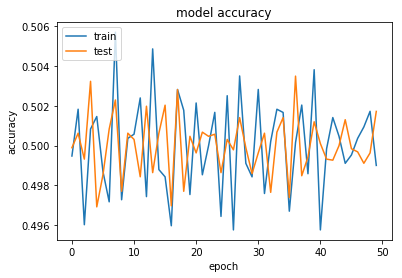

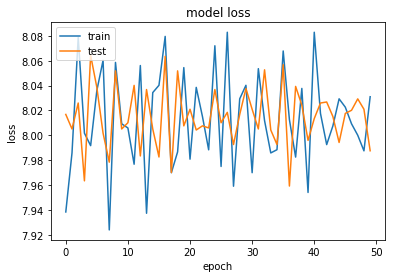

In [7]:
# Plot the different training
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
# serialize model to JSON
model_json = final_model.to_json()
with open("vgg16_ep10.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
final_model.save_weights("vgg16_ep.h5")
print("Saved model to disk")

Saved model to disk


In [9]:
print("[INFO] evaluating network...")
test_generator.reset()
predIdxs = final_model.predict_generator(test_generator, steps=(test_generator.classes.size/batch_size))

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

[INFO] evaluating network...


In [10]:
# show a nicely formatted classification report
print('------------------ Confusion Matrix -------------------')
print(confusion_matrix(test_generator.classes, predIdxs))
print(' ')
print('---------------- Classification report ----------------')
print(classification_report(test_generator.classes, predIdxs))
print(' ')
print('--------------------- AUC score -----------------------')
print(roc_auc_score(test_generator.classes, predIdxs))
print(' ')
print('------------------- Accuracy score --------------------')
print(accuracy_score(test_generator.classes, predIdxs))

------------------ Confusion Matrix -------------------
[[3999    0]
 [3999    0]]
 
---------------- Classification report ----------------
              precision    recall  f1-score   support

           0       0.50      1.00      0.67      3999
           1       0.00      0.00      0.00      3999

   micro avg       0.50      0.50      0.50      7998
   macro avg       0.25      0.50      0.33      7998
weighted avg       0.25      0.50      0.33      7998

 
--------------------- AUC score -----------------------
0.5
 
------------------- Accuracy score --------------------
0.5


/data/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
